In [3]:
ls ../scotus/data


scotus_filtered.rda  scotus_sample.rda


In [5]:
pip install -q pyreadr

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import pyreadr
result = pyreadr.read_r('../scotus/data/scotus_filtered.rda')

In [6]:
df = result["scotus_filtered"]

# EDA

In [18]:
df["text"].apply(len).describe()

count     10000.000000
mean      25857.630400
std       30323.922087
min        1001.000000
25%        8024.500000
50%       16167.500000
75%       32483.000000
max      761526.000000
Name: text, dtype: float64

In [28]:
df.year

0       1903
1       1987
2       1957
3       1913
4       1826
        ... 
9995    1904
9996    1827
9997    1947
9998    1982
9999    1998
Name: year, Length: 10000, dtype: object

# Embeddings

In [70]:
import pandas as pd
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
t5_model = SentenceTransformer('sentence-transformers/sentence-t5-base')


In [20]:
df["text_embedding"] = df["text"].apply(lambda x: model.encode(x))

In [71]:
df["t5_text_embedding"] = df["text"].apply(lambda x: t5_model.encode(x))

In [73]:
t5_embedding_df = pd.DataFrame(df.t5_text_embedding.tolist(), index= df.index)
t5_embedding_df.to_csv("scotus_embeddings/t5-scotus_embeddings.csv")

In [24]:
embedding_df = pd.DataFrame(df.text_embedding.tolist(), index= df.index)
embedding_df.to_csv("scotus_embeddings/paraphrase-scotus_embeddings.csv")

In [20]:
embedding_df = pd.read_csv("scotus_embeddings/paraphrase-scotus_embeddings.csv")

# Train

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding_df.to_numpy(),df.year.apply(float).to_numpy())

In [22]:
import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, max_depth=5, seed = 123)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred = clf.predict(X_test)

28.059805248673346


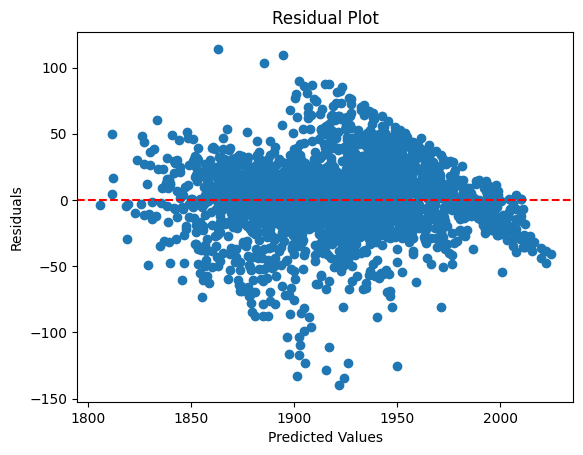

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], residuals[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [80]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,0.424180
std,25.071975
min,-173.353027
25%,-13.665680
50%,0.728516
75%,15.302277
max,118.460449


# Count Vectorize

In [7]:
import nltk 
import re 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('punkt_tab')

vectorizer = CountVectorizer(
    max_features=1000,
    stop_words=stopwords.words('english'),
    token_pattern=r"[a-zA-Z]+"
)  # Limit to top 1000 words
word_counts = vectorizer.fit_transform(
    df["text"],
)

unigram_df = pd.DataFrame(
    word_counts.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexanderpeterson/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(unigram_df.to_numpy(),df.year.apply(float).to_numpy())

In [9]:
import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, max_depth=5, seed = 123)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = clf.predict(X_test)

5.7588098963481755


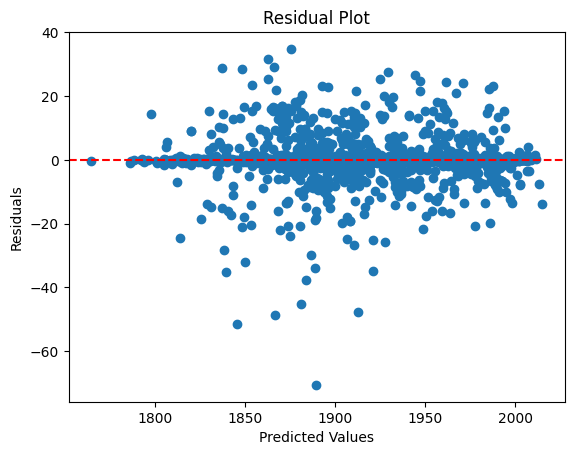

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], residuals[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [16]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,0.083815
std,12.498360
min,-111.279419
25%,-5.324860
50%,0.248535
75%,6.004883
max,103.240601
